In [1]:
# 上集 https://www.youtube.com/watch?v=c0k-YLQGKjY
# 下集 https://www.youtube.com/watch?v=kGdbPnMCdOg
# 天气预测
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_file_path = '../../data/jena_climate_2009_2016.csv'
if not os.path.exists(data_file_path):
    print(f"数据文件不存在: {data_file_path}")
else:
    raw_data = pd.read_csv(data_file_path)
    print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None


In [2]:
df = raw_data[5::6].copy()  # interval = 1 hour
print(df.head())

              Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
5   01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
11  01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
17  01.01.2009 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
23  01.01.2009 04:00:00    996.99     -9.05    264.34       -10.02    92.6   
29  01.01.2009 05:00:00    997.46     -9.63    263.72       -10.65    92.2   

    VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
5           3.33          3.14          0.19       1.96             3.15   
11          3.12          2.90          0.21       1.81             2.91   
17          3.13          2.93          0.20       1.83             2.94   
23          3.07          2.85          0.23       1.78             2.85   
29          2.94          2.71          0.23       1.69             2.71   

    rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
5        1307.86    

In [3]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.drop(columns=['Date Time'], inplace=True)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


<Axes: xlabel='Date Time'>

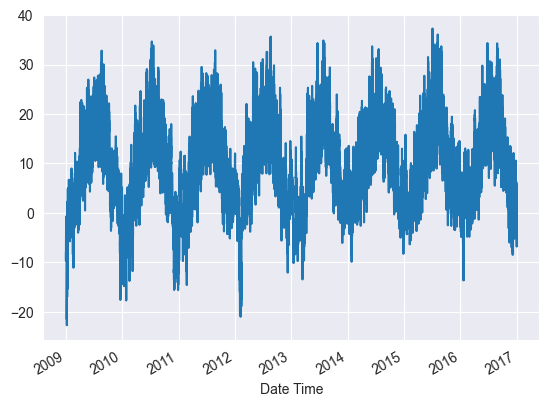

In [4]:
temp = df['T (degC)']
temp.plot()

In [5]:
# x1 = [1, 2, 3, 4, 5], y1 = [6]
# x2 = [2, 3, 4, 5, 6], y2 = [7]
# x3 = [3, 4, 5, 6, 7], y3 = [8]
# 注意RNN神经元输入张量形状是[batch_size, time_steps, features]
def prepare_dataset(input_df: pd.DataFrame, window_size: int = 5):
    df_np = input_df.to_numpy()
    X, y = [], []  # 初始化 X 和 y
    for i in range(len(df_np) - window_size):
        row = [[a] for a in df_np[i:i + window_size]]
        X.append(row)
        label = df_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)


X, y = prepare_dataset(temp, 5)
print(X.shape, y.shape)

(70086, 5, 1) (70086,)


In [9]:
print(X[0:2])

[[[-8.05]
  [-8.88]
  [-8.81]
  [-9.05]
  [-9.63]]

 [[-8.88]
  [-8.81]
  [-9.05]
  [-9.63]
  [-9.67]]]


In [6]:
X_train, y_train = X[:60000], y[:60000]
X_valid, y_valid = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(60000, 5, 1) (60000,)
(5000, 5, 1) (5000,)
(5086, 5, 1) (5086,)


In [32]:
# pip install tensorflow-cpu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Dense, Dropout, Conv1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [24]:
# LSTM模型及训练
model_1 = Sequential()
model_1.add(InputLayer(shape=(X_train.shape[1], X_train.shape[2])))
model_1.add(LSTM(64))
model_1.add(Dropout(0.1))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, activation='linear'))
ckpt_1 = ModelCheckpoint(
    '../../checkpoints/model_1_epoch-{epoch:02d}_val_loss-{val_loss:.4f}.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, callbacks=[ckpt_1])

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 70.3548 - root_mean_squared_error: 8.0711 - val_loss: 1.2161 - val_root_mean_squared_error: 1.1028
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.9917 - root_mean_squared_error: 1.7256 - val_loss: 0.6362 - val_root_mean_squared_error: 0.7976
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.5068 - root_mean_squared_error: 1.2267 - val_loss: 0.5560 - val_root_mean_squared_error: 0.7457
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1667 - root_mean_squared_error: 1.0800 - val_loss: 0.5415 - val_root_mean_squared_error: 0.7359
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0961 - root_mean_squared_error: 1.0469 - val_loss: 0.5254 - val_root_mean_squared_error: 0.7249
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0576 - root_mean_squared_error: 1.0283 - val_loss: 0.5102 - val_root_mean_squared_error: 0.7143
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━

In [8]:
inference = load_model('../../checkpoints/model_1_epoch-30_val_loss-0.4845.keras')
train_pred = inference.predict(X_train).flatten()
train_df = pd.DataFrame({'Train Predictions': train_pred, 'Actuals': y_train})
valid_pred = inference.predict(X_valid).flatten()
valid_df = pd.DataFrame({'Valid Predictions': valid_pred, 'Actuals': y_valid})
test_pred = inference.predict(X_test).flatten()
test_df = pd.DataFrame({'Test Predictions': test_pred, 'Actuals': y_test})
test_df.head()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


,Test Predictions,Actuals
0,14.335546,13.99
1,13.159682,13.46
2,12.870465,12.93
3,12.445752,12.43
4,12.010755,12.17


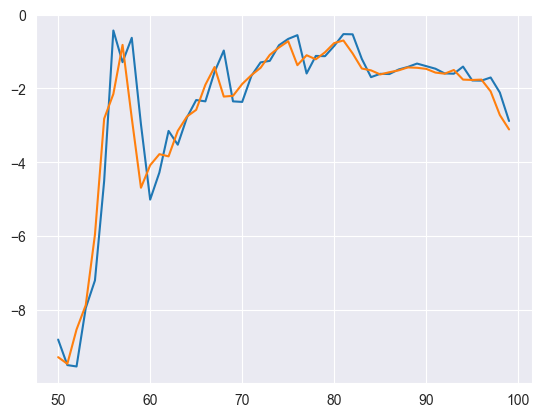

In [26]:
plt.plot(train_df['Train Predictions'][50:100])
plt.plot(train_df['Actuals'][50:100])
plt.show()

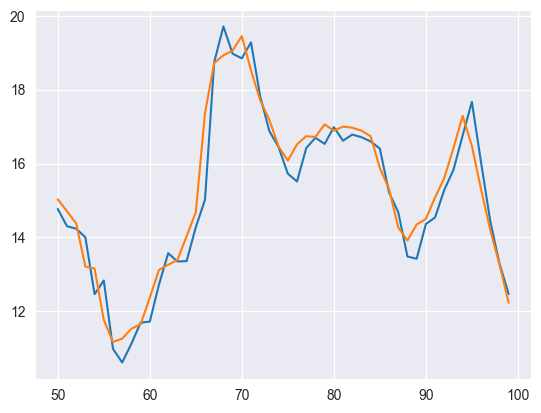

In [28]:
plt.plot(valid_df['Valid Predictions'][50:100])
plt.plot(valid_df['Actuals'][50:100])
plt.show()

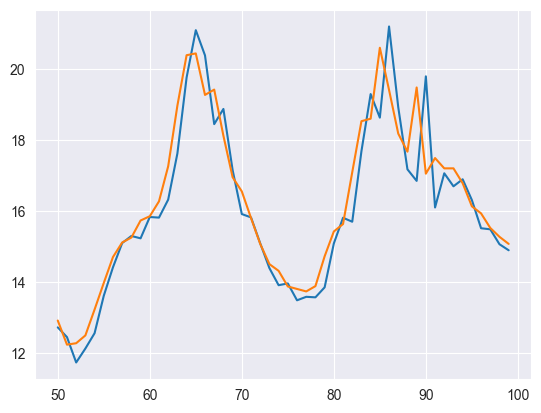

In [30]:
plt.plot(test_df['Test Predictions'][50:100])
plt.plot(test_df['Actuals'][50:100])
plt.show()

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(      Predictions  Actuals
 0       14.335546    13.99
 1       13.159682    13.46
 2       12.870465    12.93
 3       12.445752    12.43
 4       12.010755    12.17
 ...           ...      ...
 5081    -1.064029    -0.98
 5082    -1.496847    -1.40
 5083    -1.696636    -2.75
 5084    -2.978246    -2.89
 5085    -3.091293    -3.93
 
 [5086 rows x 2 columns],
 0.6606010778628679)

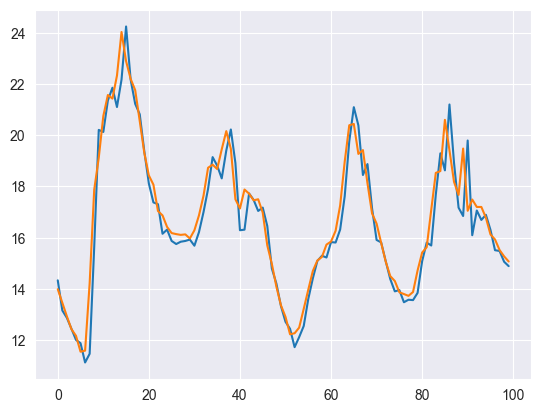

In [9]:
# part2: https://www.youtube.com/watch?v=kGdbPnMCdOg
from sklearn.metrics import mean_squared_error as mse


def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame({'Predictions': predictions, 'Actuals': y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)


inference = load_model('../../checkpoints/model_1_epoch-30_val_loss-0.4845.keras')
plot_predictions(inference, X_test, y_test)

In [28]:
# Slide window
model_2 = Sequential()
model_2.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_2.add(Conv1D(filters=64, kernel_size=2))
model_2.add(Flatten())
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))
model_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
ckpt_2 = ModelCheckpoint('../../checkpoints/model_2_epoch-{epoch:02d}_val_loss-{val_loss:.4f}.keras',
                         save_best_only=True,
                         monitor='val_loss',
                         mode='min'
                         )
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, callbacks=[ckpt_2])

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 20.6171 - root_mean_squared_error: 4.1004 - val_loss: 0.9555 - val_root_mean_squared_error: 0.9775
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1240 - root_mean_squared_error: 1.0599 - val_loss: 0.6327 - val_root_mean_squared_error: 0.7954
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8039 - root_mean_squared_error: 0.8965 - val_loss: 0.5336 - val_root_mean_squared_error: 0.7305
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6787 - root_mean_squared_error: 0.8237 - val_loss: 0.4967 - val_root_mean_squared_error: 0.7048
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6552 - root_mean_squared_error: 0.8093 - val_loss: 0.5021 - val_root_mean_squared_error: 0.7086
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6651 - root_mean_squared_error: 0.8153 - val_loss: 0.5065 - val_root_mean_squared_error: 0.7117
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step


(      Predictions  Actuals
 0       14.267931    13.99
 1       13.132219    13.46
 2       12.813638    12.93
 3       12.407024    12.43
 4       11.973398    12.17
 ...           ...      ...
 5081    -1.084010    -0.98
 5082    -1.456921    -1.40
 5083    -1.585711    -2.75
 5084    -3.053381    -2.89
 5085    -3.165245    -3.93
 
 [5086 rows x 2 columns],
 0.6224468530717346)

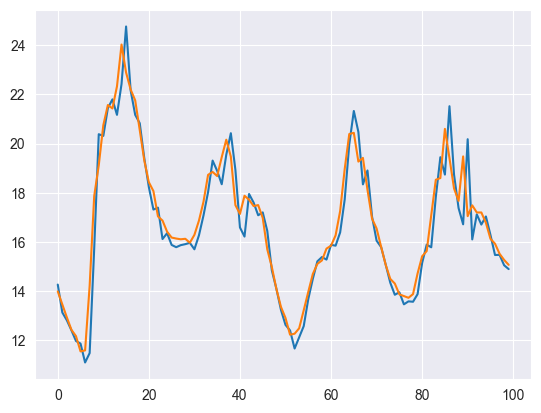

In [31]:
plot_predictions(model_2, X_test, y_test)

In [33]:
model_3 = Sequential()
model_3.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model_3.add(GRU(64))
model_3.add(Dropout(0.1))
model_3.add(Dense(8, activation='relu'))
model_3.add(Dense(1, activation='linear'))
model_3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,393 (52.32 KB)

 Trainable params: 13,393 (52.32 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
ckpt_3 = ModelCheckpoint('../../checkpoints/model_3_epoch-{epoch:02d}_val_loss-{val_loss:.4f}.keras',
                         save_best_only=True,
                         monitor='val_loss',
                         mode='min')
model_3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, callbacks=[ckpt_3])

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 49.1483 - root_mean_squared_error: 6.7420 - val_loss: 0.7970 - val_root_mean_squared_error: 0.8928
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.9385 - root_mean_squared_error: 1.3901 - val_loss: 0.5911 - val_root_mean_squared_error: 0.7688
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.2234 - root_mean_squared_error: 1.1059 - val_loss: 0.5440 - val_root_mean_squared_error: 0.7376
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0974 - root_mean_squared_error: 1.0474 - val_loss: 0.5229 - val_root_mean_squared_error: 0.7231
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0307 - root_mean_squared_error: 1.0152 - val_loss: 0.5081 - val_root_mean_squared_error: 0.7128
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0031 - root_mean_squared_error: 1.0015 - val_loss: 0.5082 - val_root_mean_squared_error: 0.7129
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(      Predictions  Actuals
 0       14.473854    13.99
 1       13.329268    13.46
 2       12.991726    12.93
 3       12.549690    12.43
 4       12.132044    12.17
 ...           ...      ...
 5081    -1.120984    -0.98
 5082    -1.390876    -1.40
 5083    -1.502111    -2.75
 5084    -3.125448    -2.89
 5085    -3.071807    -3.93
 
 [5086 rows x 2 columns],
 0.616379287932895)

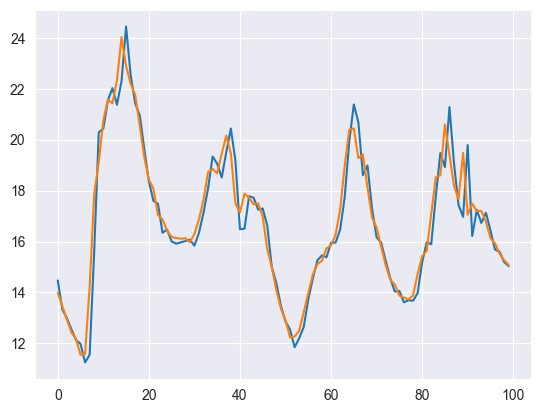

In [35]:
plot_predictions(model_3, X_test, y_test)